## Naive Bayes Model Selection

We have implemented several different variants of the Naive Bayes classifier, each with its own assumptions and characteristics. To determine which model performs best for our specific dataset, we will conduct a model selection process using some resampling technique.

### Choice of Resampling Technique

By default, we will use k-fold cross-validation for model selection and hyperparameter tuning. However, in some algorithms, training is extremely costly, and in such cases, because we have a large dataset, we may opt for a simple train-validation split instead. The choice of resampling technique will be made based on the computational cost of training each model.

Note that in all cases, the test set will remain untouched until the final evaluation phase.

### Model Space

We will consider the following Naive Bayes variants for model selection:
1. Gaussian Naive Bayes Variants:
   1. Gaussian Naive Bayes (As a baseline model): The standard Gaussian Naive Bayes model that assumes features are normally distributed.
      1. Dropping rows with missing values
      2. Dropping features with missing values
   2. Robust Gaussian Naive Bayes: A variant of the Gaussian Naive Bayes that uses the missingness of a feature as an additional categorical feature. (`laplace_smoothing in [0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]`)
   3. Categorical-Aware Robust Gaussian Naive Bayes with: A variant of the Robust Gaussian Naive Bayes that treats continuous features as independent of one another (as does the standard Naive Bayes model) but dependent on the categorical features (not the missingness indicators). (`laplace_smoothing in [0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]`)
2. Histogram-Based Naive Bayes Variants:
   1. Histogram Naive Bayes: A Naive Bayes model that uses histograms to estimate the probability density functions of continuous features.
      1. Dropping rows with missing values (`bins in range(10, 1000, 10) + [None]`)
      2. Dropping features with missing values (`bins in range(10, 1000, 10) + [None]`)
   2. Robust Histogram Naive Bayes: A variant of the Histogram Naive Bayes that incorporates missingness indicators as additional categorical features. (`bins in range(10, 1000, 10) + [None]`, `laplace_smoothing in [0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]`)
   3. Categorical-Aware Robust Histogram Naive Bayes: A variant of the Robust Histogram Naive Bayes that treats continuous features as independent of one another but dependent on the categorical features. (`bins in range(10, 1000, 10) + [None]`, `laplace_smoothing in [0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]`)
3. Kernel Density Estimation (KDE) Based Naive Bayes Variants:
   1. Gaussian KDE Naive Bayes: A Naive Bayes model that uses Kernel Density Estimation with a Gaussian Kernel to estimate the probability density functions of continuous features.
      1. Dropping rows with missing values (`bandwidth in [0.05, 0.1, 1, None]`, `num_points in [100, 1000, 5000]`, `range_padding = 0.1`)
      2. Dropping features with missing values (`bandwidth in [0.05, 0.1, 1, None]`, `num_points in [100, 1000, 5000]`, `range_padding = 0.1`)
   2. Robust Gaussian KDE Naive Bayes: A variant of the KDE Naive Bayes that incorporates missingness indicators as additional categorical features. (`bandwidth in [0.05, 0.1, 1, None]`, `num_points in [100, 1000, 5000]`, `range_padding = 0.1`, `laplace_smoothing in <about_the_best_as_in_previous_models> + [0]`)
   3. Categorical-Aware Robust Gaussian KDE Naive Bayes: A variant of the Robust KDE Naive Bayes that treats continuous features as independent of one another but dependent on the categorical features. (`bandwidth in [0.05, 0.1, 1, None]`, `num_points in [100, 1000, 5000]`, `range_padding = 0.1`, `laplace_smoothing in <about_the_best_as_in_previous_models> + [0]`)
   > **Note:** KDE models are by design lazily evaluated, meaning that training consists on just storing all the training data, and actual density estimation is performed at prediction time. Therefore, they are extremely costly to evaluate. For that reason, an **approximation** is used instead, where a large-enough sample of the feature axis is drawn and the density is estimated at those points only, using them to approximate the density at prediction time via 1-nearest-neighbor.
4. Yeo-Johnson Transformed Gaussian Naive Bayes Variants:
   1. Yeo-Johnson Transformed Gaussian Naive Bayes: A Naive Bayes model that applies a Yeo-Johnson transformation to continuous features before modeling them with Gaussian distributions.
      1. Dropping rows with missing values
      2. Dropping features with missing values
   2. Robust Yeo-Johnson Transformed Gaussian Naive Bayes: A variant of the Yeo-Johnson Transformed Gaussian Naive Bayes that incorporates missingness indicators as additional categorical features. (`laplace_smoothing in [0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]`)
   3. Categorical-Aware Robust Yeo-Johnson Transformed Gaussian Naive Bayes: A variant of the Robust Yeo-Johnson Transformed Gaussian Naive Bayes that treats continuous features as independent of one another but dependent on the categorical features. (`laplace_smoothing in [0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]`)


> **Note:** In all cases, categorical features are modeled using a multi-class generalization of the Bernoulli distribution ($f(x=i|\vec{p})=p_i$), while continuous features are modeled using different Density Estimation techniques (Gaussian, KDE, or Histogram).

In [1]:
# Load the data and prepare the clean variables.
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/train_no_preprocess.csv")
df.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,90.901,85.570,75.316,40.945,NaN,NaN,NaN,1.869,3.111,135.816,...,1,42.605,-1.962,-2.519,NaN,NaN,NaN,42.605,0.589395,b
1,133.477,3.669,99.223,227.121,2.243,365.016,2.278,1.223,3.539,440.917,...,2,173.249,-0.759,2.545,87.317,-3.002,-2.594,260.566,0.000461,s
2,115.111,26.919,77.658,50.266,NaN,NaN,NaN,2.691,3.655,133.495,...,1,53.895,0.685,-0.613,NaN,NaN,NaN,53.895,0.623627,b
3,NaN,83.642,74.642,25.176,NaN,NaN,NaN,2.646,25.176,53.813,...,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.772114,b
4,81.958,7.074,46.894,90.979,0.952,83.883,-0.226,1.626,17.517,174.686,...,2,80.028,-0.456,-1.902,33.561,0.496,-0.555,113.589,0.418760,b


Let us first define three different data sets that we'll use for the different missing data strategies: one that drops rows with missing values, one that drops features with missing values, and one that retains all data (for the robust models). We'll store them in a dictionary for easy access later on.

In [2]:
X = df.drop(columns=["Label", "Weight"])
y = df["Label"]
weights = df["Weight"]
categorical_features = df.columns.get_indexer(["PRI_jet_num"]).tolist()

df_drop_rows = df[~X.isna().any(axis=1)].reset_index(drop=True)
X_drop_rows = df_drop_rows.drop(columns=["Label", "Weight"])
y_drop_rows = df_drop_rows["Label"]
weights_drop_rows = df_drop_rows["Weight"]
categorical_features_drop_rows = df_drop_rows.columns.get_indexer(["PRI_jet_num"]).tolist()

df_drop_cols = df.drop(columns=X.columns[X.isna().any(axis=0)])
X_drop_cols = df_drop_cols.drop(columns=["Label", "Weight"])
y_drop_cols = df_drop_cols["Label"]
weights_drop_cols = df_drop_cols["Weight"]
categorical_features_drop_cols = df_drop_cols.columns.get_indexer(["PRI_jet_num"]).tolist()

# Convert them to numpy and store them in a datasets dictionary for easy reference.
datasets = {
    "original": (X.to_numpy(), y.to_numpy(), weights.to_numpy(), categorical_features),
    "drop-rows": (
        X_drop_rows.to_numpy(),
        y_drop_rows.to_numpy(),
        weights_drop_rows.to_numpy(),
        categorical_features_drop_rows,
    ),
    "drop-columns": (
        X_drop_cols.to_numpy(),
        y_drop_cols.to_numpy(),
        weights_drop_cols.to_numpy(),
        categorical_features_drop_cols,
    ),
}
del (
    df,
    X,
    y,
    df_drop_rows,
    X_drop_rows,
    y_drop_rows,
    df_drop_cols,
    X_drop_cols,
    y_drop_cols,
    categorical_features,
    categorical_features_drop_rows,
    categorical_features_drop_cols,
)  # Free memory

Now let us define an experimenting framework that will allow us to declaratively define which models and hyperparameters to use, and easily run model selection for all the different models and hyperparameters defined above.

> **Note:** The implementation has been moved to `src/naive_bayes/experiments/__init__.py` for better modularity and reusability.

Now we're equipped to run the experiments, let's first define them:

In [3]:
import sys
import os
from numpy.typing import NDArray

from typing import List, Self, Tuple, Dict
from sklearn.model_selection import KFold


sys.path.append(os.path.abspath("../"))

from src.naive_bayes.experiments import ExperimentBase, run_all_experiments


class ModelSelectionExperiment(ExperimentBase):
    num_folds: int
    fold_index: int

    def custom_hash_items(self) -> Tuple:
        return (self.num_folds, self.fold_index)

    def custom_equals(self, other: "Self") -> bool:
        return self.num_folds == other.num_folds and self.fold_index == other.fold_index

    def _get_train_test_data(
        self, datasets: Dict[str, Tuple[NDArray, NDArray, NDArray, List[int]]]
    ) -> Tuple[NDArray, NDArray, NDArray, NDArray, NDArray, NDArray, List[int]]:
        """
        Given a dataset dictionary, return:
        - X_train
        - y_train
        - weights_train
        - X_test
        - y_test
        - weights_test
        - categorical_features
        for the current experiment's dataset and fold.
        """

        X, y, weights, categorical_features = datasets[self.dataset]

        # Create cross-validation folds
        kf = KFold(n_splits=self.num_folds, shuffle=True, random_state=42)
        for fold_index, (train, test) in enumerate(kf.split(X)):
            if fold_index == self.fold_index:
                # Skip folds that are not the current fold index, and keep only the desired fold
                break
        return X[train], y[train], weights[train], X[test], y[test], weights[test], categorical_features


experiments: List[ModelSelectionExperiment] = []

#### Gaussian experiments

In [4]:
# Gaussian Naive Bayes Variants:
num_folds = 10
# Standard
for dataset in ["drop-rows", "drop-columns"]:
    for fold_index in range(num_folds):
        experiments.append(
            ModelSelectionExperiment(
                model_class="BespokeNB",
                categorical_estimator_class="CategoricalEstimator",
                continuous_estimator_class="GaussianEstimator",
                dataset=dataset,
                num_folds=num_folds,
                fold_index=fold_index,
            )
        )

# Robust and categorical-aware
for laplace_smoothing in [0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    for fold_index in range(num_folds):
        experiments.append(
            ModelSelectionExperiment(
                model_class="BespokeNB",
                categorical_estimator_class="RobustCategoricalEstimator",
                continuous_estimator_class="RobustGaussianEstimator",
                dataset="original",
                num_folds=num_folds,
                fold_index=fold_index,
                continuous_estimator_params=dict(laplace_smoothing=laplace_smoothing),
            )
        )

        experiments.append(
            ModelSelectionExperiment(
                model_class="CategoricalAwareBespokeNB",
                categorical_estimator_class="RobustCategoricalEstimator",
                continuous_estimator_class="RobustGaussianEstimator",
                dataset="original",
                num_folds=num_folds,
                fold_index=fold_index,
                continuous_estimator_params=dict(laplace_smoothing=laplace_smoothing),
            )
        )

#### Histogram experiments

In [5]:
# Histogram Naive Bayes Variants:
num_folds = 10
# Standard
for dataset in ["drop-rows", "drop-columns"]:
    for bins in list(range(10, 1000, 10)) + [None]:
        for fold_index in range(num_folds):
            experiments.append(
                ModelSelectionExperiment(
                    model_class="BespokeNB",
                    categorical_estimator_class="CategoricalEstimator",
                    continuous_estimator_class="HistogramEstimator",
                    dataset=dataset,
                    num_folds=num_folds,
                    fold_index=fold_index,
                    continuous_estimator_params=dict(bins=bins),
                )
            )

# Robust and categorical-aware
for laplace_smoothing in [0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    for bins in list(range(10, 1000, 10)) + [None]:
        for fold_index in range(num_folds):
            experiments.append(
                ModelSelectionExperiment(
                    model_class="BespokeNB",
                    categorical_estimator_class="RobustCategoricalEstimator",
                    continuous_estimator_class="RobustHistogramEstimator",
                    dataset="original",
                    num_folds=num_folds,
                    fold_index=fold_index,
                    continuous_estimator_params=dict(laplace_smoothing=laplace_smoothing, bins=bins),
                )
            )

            experiments.append(
                ModelSelectionExperiment(
                    model_class="CategoricalAwareBespokeNB",
                    categorical_estimator_class="RobustCategoricalEstimator",
                    continuous_estimator_class="RobustHistogramEstimator",
                    dataset="original",
                    num_folds=num_folds,
                    fold_index=fold_index,
                    continuous_estimator_params=dict(laplace_smoothing=laplace_smoothing, bins=bins),
                )
            )

Let us skip the KDE estimators, as they are much much more computationally expensive to run, and perform first the Yeo-Johnson experiments. After that, we can explore the temporary results, and narrow down which hyperparameters to explore for the KDE models.

#### Yeo-Johnson experiments

In [6]:
# Yeo-Johnson Gaussian Naive Bayes Variants:
num_folds = 10
# Standard
for dataset in ["drop-rows", "drop-columns"]:
    for fold_index in range(num_folds):
        experiments.append(
            ModelSelectionExperiment(
                model_class="BespokeNB",
                categorical_estimator_class="CategoricalEstimator",
                continuous_estimator_class="YeoJohnsonGaussianEstimator",
                dataset=dataset,
                num_folds=num_folds,
                fold_index=fold_index,
            )
        )

# Robust and categorical-aware
for laplace_smoothing in [0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    for fold_index in range(num_folds):
        experiments.append(
            ModelSelectionExperiment(
                model_class="BespokeNB",
                categorical_estimator_class="RobustCategoricalEstimator",
                continuous_estimator_class="RobustYeoJohnsonGaussianEstimator",
                dataset="original",
                num_folds=num_folds,
                fold_index=fold_index,
                continuous_estimator_params=dict(laplace_smoothing=laplace_smoothing),
            )
        )

        experiments.append(
            ModelSelectionExperiment(
                model_class="CategoricalAwareBespokeNB",
                categorical_estimator_class="RobustCategoricalEstimator",
                continuous_estimator_class="RobustYeoJohnsonGaussianEstimator",
                dataset="original",
                num_folds=num_folds,
                fold_index=fold_index,
                continuous_estimator_params=dict(laplace_smoothing=laplace_smoothing),
            )
        )

And finally, let's run the experiments and collect the results:

In [7]:
import warnings

np.seterr(divide="ignore", invalid="ignore")
with warnings.catch_warnings():
    run_all_experiments(
        experiments=set(experiments),
        datasets=datasets,
        results_file="../results/experiments-results.jsonl",
        failed_file="../results/experiments-failed.jsonl",
    )

Running experiments: 0it [00:00, ?it/s]


Before running the KDE experiments, let us explore the effects of the laplace smoothing hyperparameter on the previous models, to narrow down the search space for the KDE models.

In [8]:
import json
import pandas as pd
from typing import Optional


res = []
with open("../results/experiments-results.jsonl", "r") as f:
    for line in f:
        res.append(json.loads(line))
# Convert to DataFrame for easier analysis
res = pd.DataFrame(res)
categorical_cols = ["model_class", "categorical_estimator_class", "continuous_estimator_class", "dataset"]
for col in categorical_cols:
    res[col] = res[col].astype("category")
# Let us explore the dependency of the scores with the laplace_smoothing parameter.

# Unpack the results into columns
for field in res.iloc[0]["result"].keys():
    res[field] = res["result"].apply(lambda x: x[field])


# Now let's create a column with the laplace_smoothing value for easier plotting.
def extract_laplace_smoothing(params: dict) -> Optional[float]:
    return params.get("laplace_smoothing", None)


res["laplace_smoothing"] = res["continuous_estimator_params"].apply(extract_laplace_smoothing)

# First, filter the results for the relevant experiments (those Robust or CategoricalAware).
laplace_results = res[
    (res["continuous_estimator_class"].str.contains("Robust")) | (res["model_class"].str.contains("CategoricalAware"))
]

laplace_results.head()

,model_class,categorical_estimator_class,continuous_estimator_class,dataset,num_folds,fold_index,categorical_estimator_params,continuous_estimator_params,result,accuracy,b_recall,b_precision,b_f1_score,s_recall,s_precision,s_f1_score,ams_score,laplace_smoothing
0,CategoricalAwareBespokeNB,RobustCategoricalEstimator,RobustHistogramEstimator,drop-columns,10,9,{},"{'laplace_smoothing': 1e-07, 'bins': 520}","{'accuracy': 0.6858806613946801, 'b_recall': 0...",0.685881,0.703805,0.795453,0.746828,0.651351,0.533039,0.586286,0.428922,1.000000e-07
1,CategoricalAwareBespokeNB,RobustCategoricalEstimator,RobustHistogramEstimator,drop-columns,10,5,{},"{'laplace_smoothing': 0.001, 'bins': 730}","{'accuracy': 0.6829187634795112, 'b_recall': 0...",0.682919,0.704658,0.791346,0.745490,0.640902,0.528918,0.579550,0.439115,1.000000e-03
3,CategoricalAwareBespokeNB,RobustCategoricalEstimator,RobustHistogramEstimator,original,10,5,{},"{'laplace_smoothing': 0, 'bins': 410}","{'accuracy': 0.7313587347232207, 'b_recall': 0...",0.731359,0.739348,0.834166,0.783900,0.715918,0.586966,0.645061,0.473895,0.000000e+00
4,BespokeNB,RobustCategoricalEstimator,RobustHistogramEstimator,drop-columns,10,4,{},"{'laplace_smoothing': 0.01, 'bins': 920}","{'accuracy': 0.6580158159597412, 'b_recall': 0...",0.658016,0.530869,0.914600,0.671800,0.904073,0.498952,0.643023,0.519674,1.000000e-02
5,CategoricalAwareBespokeNB,RobustCategoricalEstimator,RobustHistogramEstimator,original,10,2,{},"{'laplace_smoothing': 1e-06, 'bins': 120}","{'accuracy': 0.6741480948957584, 'b_recall': 0...",0.674148,0.642234,0.822247,0.721177,0.735051,0.518449,0.608035,0.394734,1.000000e-06


C:\Users\mirxm\AppData\Local\Temp\ipykernel_42704\3482648260.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laplace_results["group"] = laplace_results.apply(


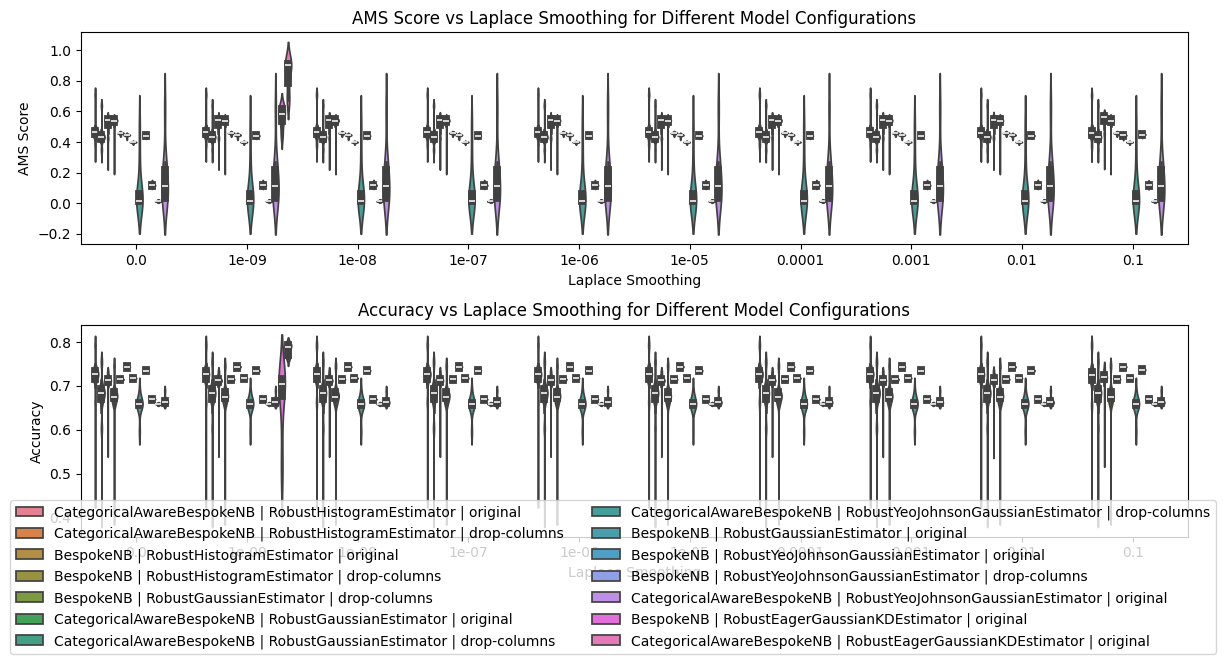

In [9]:
# Now, we can plot the AMS score against the laplace_smoothing parameter for different model configurations.
import matplotlib.pyplot as plt
import seaborn as sns

laplace_results["group"] = laplace_results.apply(
    lambda row: f"{row['model_class']} | {row['continuous_estimator_class']} | {row['dataset']}", axis=1
)
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

sns.violinplot(data=laplace_results, x="laplace_smoothing", y="ams_score", hue="group", ax=ax[0], legend=False)
ax[0].set_xlabel("Laplace Smoothing")
ax[0].set_ylabel("AMS Score")
ax[0].set_title("AMS Score vs Laplace Smoothing for Different Model Configurations")

sns.violinplot(data=laplace_results, x="laplace_smoothing", y="accuracy", hue="group", ax=ax[1], legend=True)
ax[1].set_xlabel("Laplace Smoothing")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy vs Laplace Smoothing for Different Model Configurations")
# Disable the legend, as we will create a custom one below
ax[1].legend_.remove()

plt.tight_layout()
# Add create the custom legend
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc="lower left", bbox_to_anchor=(0, -0.11))
plt.show()

After these experiments, we have found that laplace_smoothing has little to no effect on the model performance, so we will ignore it for the KDE experiments going forward.

#### KDE experiments

Note that because KDE models are more costly to evaluate, we will use a simple train-validation split instead of k-fold cross-validation for model selection, and we will also not check multiple values of the laplace_smoothing parameter, instead using the default value of `1e-9` only.

> **Note:** The most straight-forward way to run single train/validation split experiments on our existing experiment framework is to set `num_folds=math.ceil(1/validation_split)`, but add a single fold with index 0. In the runtime, the model trainer will then skip all folds except fold 0, effectively performing a single train/validation split, and because the number of folds is set to `math.ceil(1/validation_split)`, the split proportions will be correct.

In [10]:
# Gaussian KDE Naive Bayes Variants:
import math
from typing import Set

validation_split = 0.2
num_folds = math.ceil(1 / validation_split)
experiments: Set[ModelSelectionExperiment] = set()

# Standard
for dataset in ["drop-rows", "drop-columns"]:
    for bandwidth in [None, 0.05, 0.1, 1]:
        for num_points in [100, 1000, 5000]:
            experiments.add(
                ModelSelectionExperiment(
                    model_class="BespokeNB",
                    categorical_estimator_class="CategoricalEstimator",
                    continuous_estimator_class="EagerGaussianKDEstimator",
                    dataset=dataset,
                    num_folds=num_folds,
                    fold_index=0,
                    continuous_estimator_params=dict(
                        bandwidth=bandwidth, num_points=num_points, range_padding=0.1, batch_size=1000
                    ),
                )
            )

# Robust and categorical-aware

for bandwidth in [None, 0.05, 0.1, 1]:
    for num_points in [100, 1000, 5000]:
        experiments.add(
            ModelSelectionExperiment(
                model_class="BespokeNB",
                categorical_estimator_class="RobustCategoricalEstimator",
                continuous_estimator_class="RobustEagerGaussianKDEstimator",
                dataset="original",
                num_folds=num_folds,
                fold_index=0,
                continuous_estimator_params=dict(
                    bandwidth=bandwidth,
                    num_points=num_points,
                    range_padding=0.1,
                    batch_size=1000,
                    laplace_smoothing=1e-9,
                ),
            )
        )

        experiments.add(
            ModelSelectionExperiment(
                model_class="CategoricalAwareBespokeNB",
                categorical_estimator_class="RobustCategoricalEstimator",
                continuous_estimator_class="RobustEagerGaussianKDEstimator",
                dataset="original",
                num_folds=num_folds,
                fold_index=0,
                continuous_estimator_params=dict(
                    bandwidth=bandwidth,
                    num_points=num_points,
                    range_padding=0.1,
                    batch_size=1000,
                    laplace_smoothing=1e-9,
                ),
            )
        )

In [11]:
np.seterr(divide="ignore", invalid="ignore")
with warnings.catch_warnings():
    run_all_experiments(
        experiments=set(experiments),
        datasets=datasets,
        results_file="../results/experiments-results.jsonl",
        failed_file="../results/experiments-failed.jsonl",
    )

Running experiments: 0it [00:00, ?it/s]
